# Kaosiung Mayor Election 2018 on PTT Analysis 

The goal of this project is to analyze the discussions for Kaohsiung City Mayor Election 2018 on the Taiwanese biggest
forum 'PTT'. 

Kaohsiung City is the second biggest city in Taiwan. Kaosiung has been ruled by DPP for twenty years. Six months before the election, the DPP candidate Chen still led the KMT candidate Han by 31%. However, Han surprisingly won the election by 53.87%, 9% more than 44.8% received by Chen. Nobody could predict before. 

Many people tried to analyze the strategy of Han. They all noticed that Han first got a high exposure rate from the internet discussions. A common question: is this a natural phenomenon, or there are cyber armies behind the scenes? 

In this project, we focus on the behavior of potential professional teams or individuals who attempt to produce discussions and series of positive/negative comments to support/attack specific candidates. We hope this study can help people to identify patterns of information manipulation. 

## Summary

* Identify groups of frequent authors and suspicious authors
* Study the difference of articles posted by each group
* Study the pushes and boos from users of each group

## Specialty about PTT (the biggest forum in Taiwan):

* Push/boo (often used to filter articles on large board)
* The IP are recorded frequently. 
* Users are anonymous and they need to register for accounts (registration currently closed)

## Data set: 
* We used crawler to get all articles on the biggest board 'Gossipings' on PTT with keyword '韓國瑜'(Han) or '陳其邁'(Chen) from 2018/5/28 (a poll shows Chen led by 31%) to 2018/11/23 (one day before election). 
* The file 'Raw_data.csv' contains all articles on PTT with keyword '韓國瑜' from 2018/4/9 (the day he started election campaign) to 2018/12/24 (one month after he was elected). 

In [1]:
import json
import matplotlib.pyplot as plt

## Part I: Identify frequent authors and suspicious users

Usually professoional users will
* be more active than normal users, especially in posting articles, pushes and boos
* use many IP address
* one person may use many ID (PTT is an anonymous forum and there is strict rule to post article in big boards)
* be active only in work time

A function to collect the relationship between ID and IP. 

In [27]:
def count(filename):
    # read file, Chinese file name okay
    with open(filename, 'r') as myfile:
        data = myfile.read()
    # parse file
    obj = json.loads(data)
    # Ignore abnormal data
    for article in obj[u'articles']:
        if 'error' in article:
            continue    
        global g_no_articles    
        g_no_articles += 1    
        # get correct author 
        author = article['author']
        if not author:
            author = 'da1221 '
        space = author.find(' ')
        author = author[:space]
        # get IP
        ip = article['ip']    
        
        # update ip_author
        if ip in ip_author:
            ip_author[ip].add(author)        
        else:
            ip_author[ip] = {author}
        
        # update author_IP    
        if author in author_IP:
            author_IP[author].append(ip)
        else:
            author_IP[author] = [ip]             

In [3]:
# ip_author : dict, key = ip, value = {users used this ip}
# author_IP: dict, key = author, value = [IP used by this author]
ip_author = {}
author_IP = {}
g_no_articles = 0
count('Han/Gossiping-5758-10000-韓國瑜.json')
for i in range(10, 25):
    filename = 'Han/Gossiping-{}001-{}000-韓國瑜.json'.format(i, i+1)
    count(filename)
count('Han/Gossiping-25001-25463-韓國瑜.json')

IP shared by more than > 3 other people

In [4]:
share_IP = [(ip, ip_author[ip])  for ip in ip_author if len(ip_author[ip]) > 3]
#share_IP

It looks like authors did't share IP much. 

There are lots of users who used multi IP to post articles. 
Here are the list of people who uses more than 5 IPs and how many IP they used. 

In [5]:
multiIP = [(author, len(set(author_IP[author]))) for author in author_IP if len(set(author_IP[author])) >= 5]
#print sorted(multiIP, key = lambda x: -x[1]) 

At this point we realized that our data set doesn't record ip from push/boos. Only the ip from authors is not large enough. So we turn to the data collected by CommonWealth Magazine, because it contains all articles about Han on PTT, a large portion of them has been deleted now. 

## Process data from the CommonWealth Magazine
The file 'Raw_data.csv' contains all articles on PTT with keyword '韓國瑜' from 2018.4.9 (the day he started election campaign) to 2018/12/24 (one month after he was elected). 

In [6]:
import pandas as pd
cw_data = pd.read_csv('Raw_data.csv')

## Definition of a frequent user: 
* a person who post >= 30 articles about Han on PTT in this period

In [7]:
# cw_id_articles = {(uid: the number of articles this uid post)}
cw_id_articles = {}
for uid in cw_data['uid']:
    space = uid.find(" ")
    uid = uid[:space]
    if uid in cw_id_articles:
        cw_id_articles[uid] += 1
    else:
        cw_id_articles[uid] = 1  

# The lists of (uid, the number of articles of this uid) if this user posts >= 30 articles
frequent_authors = [uid  for uid in cw_id_articles if cw_id_articles[uid] >= 30] 
no_articles = len(cw_data['uid'])
no_authors = len(cw_id_articles) 
no_articles_freq = sum(cw_id_articles[uid] for uid in frequent_authors)
no_freq_authors = len(frequent_authors)

In [8]:
# The list of frequent authors
#print sorted(frequent_authors, key= lambda x: x[0])

## Definition of suspicious users:
A person is considered to be a suspicious user if he/she:
* post more than 60 articles about Han (total: 16096)
* post more than 30 articles about Han or he/she used more than 8 IPs to post articles about Han on Gossipings.

Now we analyze the number of articles contributed by suspicious users. 

In [9]:
# sus_users = [[sus uid: the number of articles this uid post]]
sus_users = set(uid for uid in cw_id_articles if cw_id_articles[uid] >= 60)
for uid in frequent_authors:
    if uid in author_IP: 
        if len(set(author_IP[uid]))>= 8:
            sus_users.add(uid)
#sus_user     
no_sus_users = len(sus_users)
no_articles_sus = sum(cw_id_articles[uid] for uid in sus_users)

In [10]:
print 'In the data collected by CommonWealth Magazine,'
print "total number of authors, frequent authors, suspecious users"
print "{}, {}({:0.2f}%), {}({:0.2f}%)".format(no_authors, len(frequent_authors), 100.0*len(frequent_authors)/no_authors,
                          len(sus_users), 100.0* len(sus_users)/no_authors)     
print "total number of articles, number of articles by frequent authors, number of articles by suspicious users"
print "{}, {}({:0.2f}%), {}({:0.2f}%)".format(no_articles, no_articles_freq, 100.0*no_articles_freq/no_articles,
                          no_articles_sus, 100.0* no_articles_sus/no_articles)     

In the data collected by CommonWealth Magazine,
total number of authors, frequent authors, suspecious users
3794, 70(1.85%), 34(0.90%)
total number of articles, number of articles by frequent authors, number of articles by suspicious users
16096, 3452(21.45%), 2031(12.62%)


In [11]:
print 'In the data from Gossipings board with keyword Han,'
print "total number of authors, frequent authors, suspecious users"
print "{}, {}({:0.2f}%), {}({:0.2f}%)".format(no_authors, len(frequent_authors), 100.0*len(frequent_authors)/no_authors,
                          len(sus_users), 100.0* len(sus_users)/no_authors)  
g_no_articles_sus = sum(len(author_IP.get(author,[])) for author in sus_users)
g_no_articles_freq = sum(len(author_IP.get(author,[])) for author in frequent_authors)
print "total number of articles, number of articles by frequent authors, number of articles by suspicious users"
print "{}, {}({:0.2f}%), {}({:0.2f}%)".format(g_no_articles, g_no_articles_freq, 100.0*g_no_articles_freq/g_no_articles,
                          g_no_articles_sus, 100.0* g_no_articles_sus/g_no_articles)     

In the data from Gossipings board with keyword Han,
total number of authors, frequent authors, suspecious users
3794, 70(1.85%), 34(0.90%)
total number of articles, number of articles by frequent authors, number of articles by suspicious users
6113, 872(14.26%), 669(10.94%)


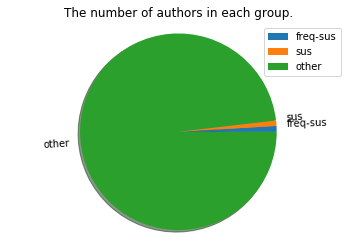

In [12]:
labels = 'freq-sus', 'sus', 'other'
sizes = [100.0*(len(frequent_authors)-len(sus_users))/no_authors, 100.0* len(sus_users)/no_authors, 
         100.0*(no_authors- len(frequent_authors))/no_authors]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, shadow=True, startangle=0, rotatelabels = True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax = plt.gca()
ax.set_title('The number of authors in each group.')
plt.legend()
plt.show()

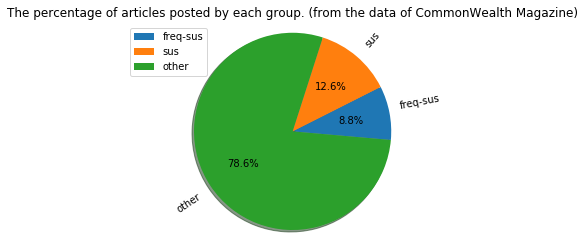

In [13]:
labels = 'freq-sus', 'sus', 'other'
sizes = [100.0*(no_articles_freq-no_articles_sus)/no_articles, 100.0* no_articles_sus/no_articles, 
         100.0*(no_articles- no_articles_freq)/no_articles]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, shadow=True, startangle=-5,rotatelabels = True, autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax = plt.gca()
ax.set_title('The percentage of articles posted by each group. (from the data of CommonWealth Magazine)')
plt.legend()
plt.show()

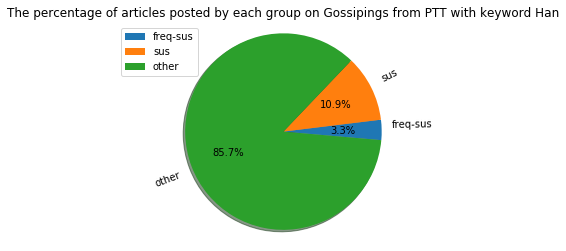

In [14]:
labels = 'freq-sus', 'sus', 'other'
sizes = [100.0*(g_no_articles_freq-g_no_articles_sus)/g_no_articles, 100.0* g_no_articles_sus/g_no_articles, 
         100.0*(g_no_articles- g_no_articles_freq)/g_no_articles]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, shadow=True, startangle=-5,rotatelabels = True, autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax = plt.gca()
ax.set_title('The percentage of articles posted by each group on Gossipings from PTT with keyword Han')
plt.legend()
plt.show()

## Part 2 Analyze articles with keyword 'Han'

For each article in Gossipings with keyword '韓國瑜'(Han), we now study the push and boos for 
three groups: all people/frequent authors/suspecious users. 

### 2.1 Process Data

In [15]:
import pandas as pd
import numpy as np

In [16]:
def push_count(filename, freq_users, sus_users):
    # read file, Chinese file name okay
    with open(filename, 'r') as myfile:
        data = myfile.read()
    # parse file
    obj = json.loads(data)
    for article in obj[u'articles']:
        if 'error' in article:
            continue  
        author = article['author']
        if not author:
            author = 'da1221 '
        space = author.find(' ')
        author = author[:space]
        
        result = [author, article["message_count"]['push'], article["message_count"]['boo'], 
                    article["message_count"]['neutral'], article["message_count"]['count']]
        fp, fb, fn, sp, sb, sn = 0,0,0,0,0,0
        for message in article['messages']: 
            if message["push_userid"] in freq_users:
                if message["push_tag"] == u'推': fp += 1
                elif message["push_tag"] == u'噓': fb += 1
                else: fn += 1 
            
            if message["push_userid"] in sus_users:
                if message["push_tag"] == u'推': sp += 1
                elif message["push_tag"] == u'噓': sb += 1
                else: sn += 1   
        result = result + [fp, fb, fn, fp-fb, sp, sb, sn, sp-sb]          
        push_result.append(result)

In [17]:
push_result = []
push_count('Han/Gossiping-5758-10000-韓國瑜.json', frequent_authors, sus_users)
for i in range(10, 25):
    filename = 'Han/Gossiping-{}001-{}000-韓國瑜.json'.format(i, i+1)
    push_count(filename, frequent_authors, sus_users)
push_count('Han/Gossiping-25001-25463-韓國瑜.json', frequent_authors, sus_users)

### 2.2 Group by the origin of pushes/boos

We collect the push data for all articles into the dataframe push_df

In [18]:
columns = ['author', 'all_push', 'all_boo', 'all_neutral', 'all_count', 
                     'freq_push', 'freq_boo', 'freq_neutral', 'freq_count', 
                     'sus_push', 'sus_boo', 'sus_neutral', 'sus_count']
push_df = pd.DataFrame(push_result, columns=columns)
push_df[:5]

,author,all_push,all_boo,all_neutral,all_count,freq_push,freq_boo,freq_neutral,freq_count,sus_push,sus_boo,sus_neutral,sus_count
0,opica,105,25,85,80,0,0,0,0,0,0,0,0
1,q1qaz2,46,5,56,41,0,0,0,0,0,0,0,0
2,sayt5943,8,1,14,7,0,0,0,0,0,0,0,0
3,t9404080,16,2,10,14,0,0,0,0,0,0,0,0
4,bengowa,19,21,31,-2,0,0,0,0,0,0,0,0


Next, we group these articles by the count of pushes-boos from all users. The result is push_category

In [19]:
push_category = pd.DataFrame(columns = columns[1:])
push_da = push_df.iloc[:,1:]
count = []

push_category.loc['<-100'] = push_da[push_da['all_count'] < -100].agg('sum')
for i in range(-10, 10):
    index = str(i*10) + '~' + str((i*10+9))
    push_category.loc[index] = push_da[(push_da['all_count'] >=i*10) & (push_da['all_count'] <=i*10+9)].agg('sum')
push_category.loc['>=100'] = push_da[push_da['all_count'] >=100].agg('sum')
push_category

,all_push,all_boo,all_neutral,all_count,freq_push,freq_boo,freq_neutral,freq_count,sus_push,sus_boo,sus_neutral,sus_count
<-100,1092,3588,2485,-2496,21,51,55,-30,13,40,39,-27
-100~-91,320,1076,645,-756,8,15,16,-7,6,12,16,-6
-90~-81,222,979,635,-757,3,11,15,-8,1,9,12,-8
-80~-71,153,471,279,-318,3,7,6,-4,2,2,4,0
-70~-61,306,890,634,-584,3,12,10,-9,0,10,4,-10
-60~-51,435,1039,792,-604,9,10,15,-1,8,9,15,-1
-50~-41,356,1098,1223,-742,9,26,16,-17,5,20,7,-15
-40~-31,755,1980,1448,-1225,17,40,23,-23,6,23,16,-17
-30~-21,816,1921,2068,-1105,21,47,40,-26,11,29,26,-18
-20~-11,2022,3932,4780,-1910,51,97,82,-46,33,64,54,-31


From the dataframe above, we can see the contributions from frequent authors and suspecious users are not 
significant. It means that they are more interested in posting articles. Their interest in joining the 
discussion for articles is only slightly more than other users. This is surprising because it disobeys 
our original thought. 

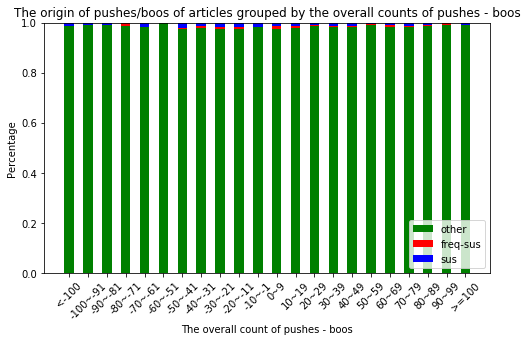

In [20]:
plt.figure(figsize=(8, 6))
push_category_other_perc = 1.0*(push_category['all_count'] - push_category['freq_count'])/ push_category['all_count']
push_category_freq_perc =1.0*(push_category['freq_count'])/ push_category['all_count']
push_category_sus_perc =1.0*(push_category['sus_count'])/ push_category['all_count']
plt.bar(push_category.index, push_category_other_perc, width = 0.5, color='g', label = 'other')
plt.bar(push_category.index, push_category_freq_perc - push_category_sus_perc, width = 0.5, 
        bottom= push_category_other_perc, color='r', label = 'freq-sus')
plt.bar(push_category.index, push_category_sus_perc, width = 0.5, bottom= 1-push_category_sus_perc, color='b', label = 'sus')
plt.legend(loc = 4)
plt.xlabel('The overall count of pushes - boos')
plt.ylabel('Percentage')
plt.title('The origin of pushes/boos of articles grouped by the overall counts of pushes - boos')
x = plt.gca().xaxis
# rotate the tick labels for the x axis
for item in x.get_ticklabels():
    item.set_rotation(45)
plt.subplots_adjust(bottom=0.3)

This chart tells us frequent authors and suspicious authors are not particular active in giving pushes and boos.

### 2.3 Group by the authors

Next, we study the count of pushes for articles posted by all/frequent authors/suspecious users. 
Questions: will articles posted by frequent authors get more pushes/boos?

We run t-tests to analyze overall push and boos count between articles posted by users in different groups. 

In [21]:
from scipy import stats
freq_push_count = push_df[push_df['author'].isin(frequent_authors)][['all_push','all_boo']]
sus_push_count = push_df[push_df['author'].isin(sus_users)][['all_push','all_boo']]
other_push_count = push_df[~push_df['author'].isin(sus_users) & ~push_df['author'].isin(sus_users)][['all_push','all_boo']]
print  stats.ttest_ind(freq_push_count, other_push_count)
print  stats.ttest_ind(sus_push_count, other_push_count)

Ttest_indResult(statistic=array([-2.67624426, -0.30750285]), pvalue=array([0.00746446, 0.75847079]))
Ttest_indResult(statistic=array([-1.73170752,  0.20833991]), pvalue=array([0.08337612, 0.83497051]))


We're confident that he articles posted by frequent authors received less pushes. For others since the p-values are high we retain and null hypothesis.

The articles are futher divided using the total count of pushes-boos. 

In [22]:
authors_cat = pd.DataFrame(columns = ['all', 'freq_authors', 'sus_users'])
in_f = push_df['author'].isin(frequent_authors) 
in_s = push_df['author'].isin(sus_users)

c_range = (push_df['all_count'] < -100) 
authors_cat.loc['< -100'] = [len(push_df[c_range]), len(push_df[c_range & in_f]), len(push_df[c_range & in_s])]
for i in range(-10, 10):
    index = str(i*10) + '~' + str((i*10+9))
    c_range = ((push_df['all_count'] >=i*10) & (push_df['all_count'] <=i*10+9))
    authors_cat.loc[index] = [len(push_df[c_range]), len(push_df[c_range & in_f]), len(push_df[c_range & in_s])]
c_range = (push_df['all_count'] >=100) 
authors_cat.loc['>=100'] = [len(push_df[c_range]), len(push_df[c_range & in_f]), len(push_df[c_range & in_s])]
authors_cat

,all,freq_authors,sus_users
< -100,16,4,3
-100~-91,8,1,1
-90~-81,9,0,0
-80~-71,4,0,0
-70~-61,9,3,3
-60~-51,11,2,2
-50~-41,16,3,2
-40~-31,35,5,4
-30~-21,44,8,4
-20~-11,132,21,14


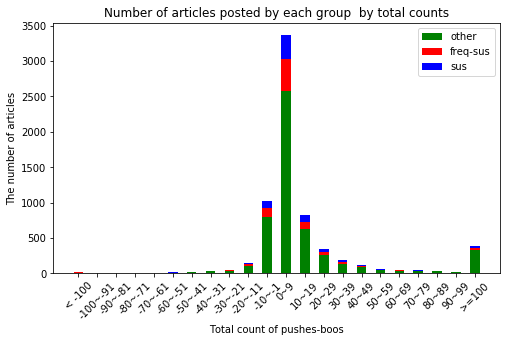

In [23]:
plt.figure(figsize=(8, 6))
other = authors_cat['all'] - authors_cat['freq_authors'] 
plt.bar(authors_cat.index, other, width = 0.5, color='g', label = 'other')
plt.bar(authors_cat.index, authors_cat['freq_authors'], width = 0.5, bottom= other, color='r', label = 'freq-sus')
plt.bar(authors_cat.index, authors_cat['sus_users'], width = 0.5, bottom= other+ authors_cat['freq_authors'], color='b', label = 'sus')
x = plt.gca().xaxis
plt.xlabel('Total count of pushes-boos')
plt.ylabel('The number of articles')
plt.title('Number of articles posted by each group  by total counts')
plt.legend()
# rotate the tick labels for the x axis
for item in x.get_ticklabels():
    item.set_rotation(45)
plt.subplots_adjust(bottom=0.3)

Let's show the percentage for each group,

In [24]:
authors_perc = pd.DataFrame()
authors_perc['freq_authors'] = 1.0*authors_cat['freq_authors']/authors_cat['all']
authors_perc['sus_users'] = 1.0*authors_cat['sus_users']/authors_cat['all']
authors_perc['other'] = 1.0*other/authors_cat['all'] 
#authors_perc

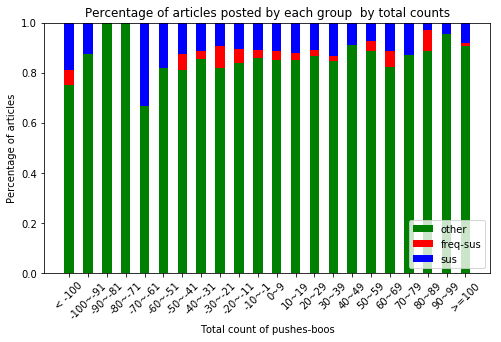

In [25]:
plt.figure(figsize=(8, 6))
plt.bar(authors_perc.index, authors_perc['other'], width = 0.5, color='g', label = 'other')
plt.bar(authors_perc.index, authors_perc['freq_authors']- authors_perc['sus_users'], width = 0.5, 
        bottom= authors_perc['other'], color='r', label = 'freq-sus')
plt.bar(authors_perc.index, authors_perc['sus_users'], width = 0.5, bottom= 1.0-authors_perc['sus_users'], 
        color='b', label = 'sus')
plt.ylim((0, 1))  
plt.xlabel('Total count of pushes-boos')
plt.ylabel('Percentage of articles')
plt.title('Percentage of articles posted by each group  by total counts')
plt.legend(loc = 4)
x = plt.gca().xaxis
# rotate the tick labels for the x axis
for item in x.get_ticklabels():
    item.set_rotation(45)
plt.subplots_adjust(bottom=0.3)

Given that frequent authors posts 14.26%, and suspicious users posts 10.94% of articles on Gossipings. Articles posted by frequent users lie more in <100, -70~-61, -30~-21, 60~69 intervals. Articles posted more by suspecious users lie more in <100, -70~-61, -60~-51, -30~-21, 70~79, 90~99 intervals and significantly less in 80_99 intervals.

Frequent authors and suspicious users seems to not care much about the push count of their articles. They didn't spend much effort in persuing high push count. On the contrary, an usual high percentage of them are boos over 100 times ('噓爆').  

## Part 3 We repeat the same analysis for articles with keyword '陳其邁'(Chen). 

###  3.1 Process Data

In [28]:
# ip_author : dict, key = ip, value = {users used this ip}
# author_IP: dict, key = author, value = [IP used by this author]
ip_author = {}
author_IP = {}
g_no_articles = 0
count('Chen/Gossiping-5758-7000-陳其邁.json')
for i in range(7, 25):
    filename = 'Chen/Gossiping-{}001-{}000-陳其邁.json'.format(i, i+1)
    count(filename)
count('Chen/Gossiping-25000-25463-陳其邁.json')

In [29]:
print 'In the data from Gossipings board with keyword Chen,'
print "total number of authors, frequent authors, suspecious users"
print "{}, {}({:0.2f}%), {}({:0.2f}%)".format(no_authors, len(frequent_authors), 100.0*len(frequent_authors)/no_authors,
                          len(sus_users), 100.0* len(sus_users)/no_authors) 
c_no_articles =g_no_articles 
c_no_articles_sus = sum(len(author_IP.get(author,[])) for author in sus_users)
c_no_articles_freq = sum(len(author_IP.get(author,[])) for author in frequent_authors)
print "total number of articles, number of articles by frequent users, number of articles by frequent users"
print "{}, {}({:0.2f}%), {}({:0.2f}%)".format(c_no_articles, c_no_articles_freq, 100.0*c_no_articles_freq/c_no_articles,
                          c_no_articles_sus, 100.0* c_no_articles_sus/c_no_articles)     

In the data from Gossipings board with keyword Chen,
total number of authors, frequent authors, suspecious users
3794, 70(1.85%), 34(0.90%)
total number of articles, number of articles by frequent users, number of articles by frequent users
2774, 357(12.87%), 268(9.66%)


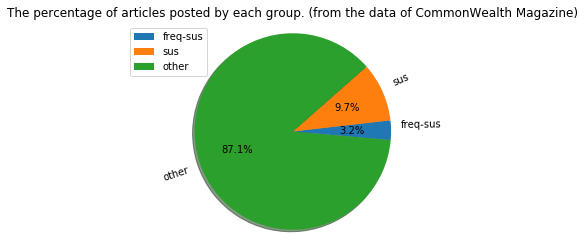

In [30]:
labels = 'freq-sus', 'sus', 'other'
sizes = [100.0*(c_no_articles_freq-c_no_articles_sus)/c_no_articles, 100.0* c_no_articles_sus/c_no_articles, 
         100.0*(c_no_articles- c_no_articles_freq)/c_no_articles]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, shadow=True, startangle=-5,rotatelabels = True, autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax = plt.gca()
ax.set_title('The percentage of articles posted by each group. (from the data of CommonWealth Magazine)')
plt.legend()
plt.show()

### 3.2 Group by the origin of pushes/boos

In [31]:
push_result = []
push_count('Chen/Gossiping-5758-7000-陳其邁.json', frequent_authors, sus_users)
for i in range(7, 25):
    filename = 'Chen/Gossiping-{}001-{}000-陳其邁.json'.format(i, i+1)
    push_count(filename, frequent_authors, sus_users)
push_count('Chen/Gossiping-25000-25463-陳其邁.json', frequent_authors, sus_users)

In [32]:
columns = ['author', 'all_push', 'all_boo', 'all_neutral', 'all_count', 
                     'freq_push', 'freq_boo', 'freq_neutral', 'freq_count', 
                     'sus_push', 'sus_boo', 'sus_neutral', 'sus_count']
push_df = pd.DataFrame(push_result, columns=columns)
push_df[:5]

,author,all_push,all_boo,all_neutral,all_count,freq_push,freq_boo,freq_neutral,freq_count,sus_push,sus_boo,sus_neutral,sus_count
0,qooisgood,48,24,43,24,0,1,0,-1,0,1,0,-1
1,dispptt,21,13,13,8,0,0,0,0,0,0,0,0
2,tetani,6,3,3,3,0,0,0,0,0,0,0,0
3,opica,105,25,85,80,0,0,0,0,0,0,0,0
4,q1qaz2,46,5,56,41,0,0,0,0,0,0,0,0


In [33]:
push_category = pd.DataFrame(columns = columns[1:])
push_da = push_df.iloc[:,1:]
count = []

push_category.loc['<-100'] = push_da[push_da['all_count'] < -100].agg('sum')
for i in range(-10, 10):
    index = str(i*10) + '~' + str((i*10+9))
    push_category.loc[index] = push_da[(push_da['all_count'] >=i*10) & (push_da['all_count'] <=i*10+9)].agg('sum')
push_category.loc['>=100'] = push_da[push_da['all_count'] >=100].agg('sum')
push_category

,all_push,all_boo,all_neutral,all_count,freq_push,freq_boo,freq_neutral,freq_count,sus_push,sus_boo,sus_neutral,sus_count
<-100,342,1619,948,-1277,4,24,25,-20,4,20,23,-16
-100~-91,88,282,171,-194,0,7,7,-7,0,4,7,-4
-90~-81,160,582,350,-422,0,9,12,-9,0,8,11,-8
-80~-71,61,208,152,-147,1,2,4,-1,1,1,4,0
-70~-61,27,94,61,-67,1,1,1,0,0,1,0,-1
-60~-51,182,631,360,-449,1,7,5,-6,0,4,4,-4
-50~-41,245,778,517,-533,4,27,16,-23,4,22,13,-18
-40~-31,596,1455,1095,-859,11,27,17,-16,4,13,13,-9
-30~-21,828,1618,1431,-790,11,34,27,-23,7,16,20,-9
-20~-11,1230,2149,2444,-919,14,39,44,-25,12,27,29,-15


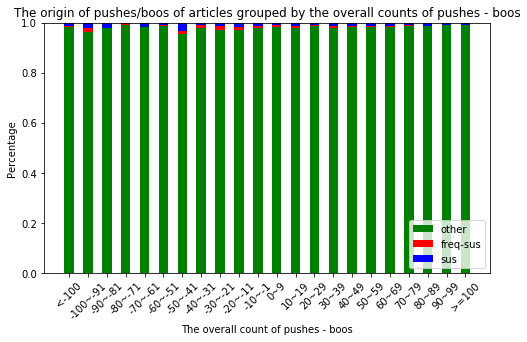

In [34]:
plt.figure(figsize=(8, 6))
push_category_other_perc = 1.0*(push_category['all_count'] - push_category['freq_count'])/ push_category['all_count']
push_category_freq_perc =1.0*(push_category['freq_count'])/ push_category['all_count']
push_category_sus_perc =1.0*(push_category['sus_count'])/ push_category['all_count']
plt.bar(push_category.index, push_category_other_perc, width = 0.5, color='g', label = 'other')
plt.bar(push_category.index, push_category_freq_perc - push_category_sus_perc, width = 0.5, 
        bottom= push_category_other_perc, color='r', label = 'freq-sus')
plt.bar(push_category.index, push_category_sus_perc, width = 0.5, bottom= 1-push_category_sus_perc, color='b', label = 'sus')
plt.legend(loc = 4)
plt.xlabel('The overall count of pushes - boos')
plt.ylabel('Percentage')
plt.title('The origin of pushes/boos of articles grouped by the overall counts of pushes - boos')
x = plt.gca().xaxis
# rotate the tick labels for the x axis
for item in x.get_ticklabels():
    item.set_rotation(45)
plt.subplots_adjust(bottom=0.3)

This chart tells us frequent authors and suspicious authors are not particular active in giving pushes and boos.

### 2.3 Group by the authors

We run t-tests to analyze overall push and boos count between articles posted by users in different groups. 

In [35]:
freq_push_count = push_df[push_df['author'].isin(frequent_authors)][['all_push','all_boo']]
sus_push_count = push_df[push_df['author'].isin(sus_users)][['all_push','all_boo']]
other_push_count = push_df[~push_df['author'].isin(sus_users) & ~push_df['author'].isin(sus_users)][['all_push','all_boo']]
print  stats.ttest_ind(freq_push_count, other_push_count)
print  stats.ttest_ind(sus_push_count, other_push_count)

Ttest_indResult(statistic=array([-0.59473757,  0.60768743]), pvalue=array([0.55206594, 0.54344303]))
Ttest_indResult(statistic=array([-0.21819395,  0.30085492]), pvalue=array([0.82729406, 0.76354769]))


The articles posted by frequent authors and suspicious users received less pushes and more boos, but since the p-values are high we retain and null hypothesis.

In [36]:
authors_cat = pd.DataFrame(columns = ['all', 'freq_authors', 'sus_users'])
in_f = push_df['author'].isin(frequent_authors) 
in_s = push_df['author'].isin(sus_users)

c_range = (push_df['all_count'] < -100) 
authors_cat.loc['< -100'] = [len(push_df[c_range]), len(push_df[c_range & in_f]), len(push_df[c_range & in_s])]
for i in range(-10, 10):
    index = str(i*10) + '~' + str((i*10+9))
    c_range = ((push_df['all_count'] >=i*10) & (push_df['all_count'] <=i*10+9))
    authors_cat.loc[index] = [len(push_df[c_range]), len(push_df[c_range & in_f]), len(push_df[c_range & in_s])]
c_range = (push_df['all_count'] >=100) 
authors_cat.loc['>=100'] = [len(push_df[c_range]), len(push_df[c_range & in_f]), len(push_df[c_range & in_s])]

authors_cat

,all,freq_authors,sus_users
< -100,8,4,3
-100~-91,2,0,0
-90~-81,5,0,0
-80~-71,2,0,0
-70~-61,1,0,0
-60~-51,8,0,0
-50~-41,12,3,1
-40~-31,24,2,1
-30~-21,31,8,5
-20~-11,64,6,5


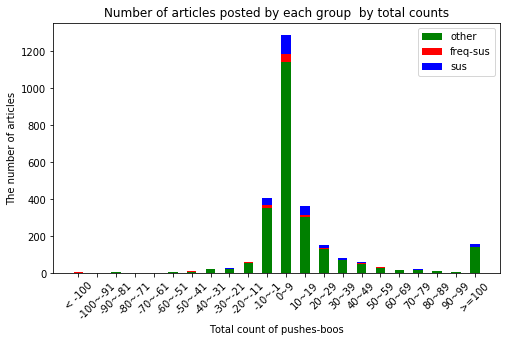

In [37]:
plt.figure(figsize=(8, 6))
other = authors_cat['all'] - authors_cat['freq_authors'] 
plt.bar(authors_cat.index, other, width = 0.5, color='g', label = 'other')
plt.bar(authors_cat.index, authors_cat['freq_authors']-authors_cat['sus_users'], width = 0.5, bottom= other, 
        color='r',  label = 'freq-sus')
plt.bar(authors_cat.index, authors_cat['sus_users'], width = 0.5, bottom= authors_cat['all'] -authors_cat['sus_users'], 
        color='b',  label = 'sus')

plt.xlabel('Total count of pushes-boos')
plt.ylabel('The number of articles')
plt.title('Number of articles posted by each group  by total counts')
plt.legend()

x = plt.gca().xaxis
# rotate the tick labels for the x axis
for item in x.get_ticklabels():
    item.set_rotation(45)
plt.subplots_adjust(bottom=0.3)

Let's show the percentage for each group,

In [38]:
authors_perc = pd.DataFrame()
authors_perc['freq_authors'] = 1.0*authors_cat['freq_authors']/authors_cat['all']
authors_perc['sus_users'] = 1.0*authors_cat['sus_users']/authors_cat['all']
authors_perc['other'] = 1.0*other/authors_cat['all'] 
authors_perc

,freq_authors,sus_users,other
< -100,0.5,0.375,0.5
-100~-91,0,0,1
-90~-81,0,0,1
-80~-71,0,0,1
-70~-61,0,0,1
-60~-51,0,0,1
-50~-41,0.25,0.0833333,0.75
-40~-31,0.0833333,0.0416667,0.916667
-30~-21,0.258065,0.16129,0.741935
-20~-11,0.09375,0.078125,0.90625


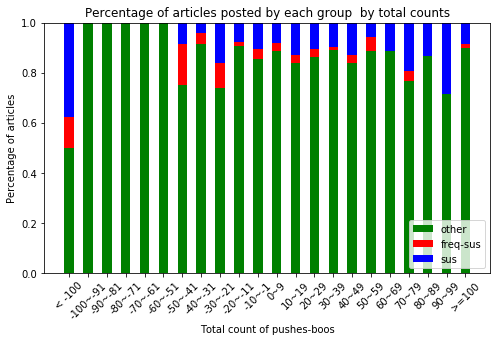

In [39]:
plt.figure(figsize=(8, 6))
plt.bar(authors_perc.index, authors_perc['other'], width = 0.5, color='g', label = 'other')
plt.bar(authors_perc.index, authors_perc['freq_authors']- authors_perc['sus_users'], width = 0.5, 
        bottom= authors_perc['other'], color='r', label = 'freq-sus')
plt.bar(authors_perc.index, authors_perc['sus_users'], width = 0.5, bottom= 1.0-authors_perc['sus_users'], 
        color='b', label = 'sus')
plt.ylim((0, 1))  
plt.xlabel('Total count of pushes-boos')
plt.ylabel('Percentage of articles')
plt.title('Percentage of articles posted by each group  by total counts')
plt.legend(loc = 4)
x = plt.gca().xaxis
# rotate the tick labels for the x axis
for item in x.get_ticklabels():
    item.set_rotation(45)
plt.subplots_adjust(bottom=0.3)

Given that frequent authors posts 12.87% and suspicious users posts 9.66% articles on Gossipsing about Chen. The 
articles posted by frequent authors lie more in <-100. -50~-41, -30~-21, 70~79 and 90~99. The articles posted by suspicious authors lie more in <-100, -30~-21, 90~99. 

## Part 4 Conclusion: 

We find two special groups of users on PTT -- frequent authors and suspicious users -- who are the most active towards posting articles for the two candidates. We find

* Their articles about Han received slightly more boos, pushes and articles about 'Chen' don't have much difference.
* They are not particularly interested in giving pushes/boos. 
* Their articles has an usual percentage of < -100 pushes - boos. This is possibly because people recognize their ID and give unfair comments just for the sake of authors. 

Between frequent authors and suspicious users we didn't more determinstic difference for their behavior. We only know suspicious users are more active and use more IP. 

## Future direction: 

* Find other tools to collect IPs for users and multiple ID for one person. 
* The response time for push and boos. 
* Different definition for suspicious users (based on pushes/boos).
* Diffferent politicians.
* Distinguish users and articles of different political inclination (NLP).